## Code to remove tilt and compliance noise from seismograms using SeisGo code
https://github.com/xtyangpsp/SeisGo/blob/master/notebooks/tcremoval_earthquakes.ipynb

In [1]:
import obspy
import matplotlib.pyplot as plt
import numpy as np
import glob
import pandas as pd
import time; import datetime
from obspy.core.utcdatetime import UTCDateTime
from obspy.clients.fdsn.client import Client
import pyasdf
import obsmaster as obs
import obsmaster_utils as utils
# from seisgo.downloaders import download,get_sta_list

In [329]:
class Power(object):
    """
    Container for power spectra for each component, with any shape

    Attributes
    ----------
    c11 : :class:`~numpy.ndarray`
        Power spectral density for component 1 (any shape)
    c22 : :class:`~numpy.ndarray`
        Power spectral density for component 2 (any shape)
    cZZ : :class:`~numpy.ndarray`
        Power spectral density for component Z (any shape)
    cPP : :class:`~numpy.ndarray`
        Power spectral density for component P (any shape)
    """

    def __init__(spectra, c11=None, c22=None, cZZ=None, cPP=None,freq=None):
        spectra.c11 = c11
        spectra.c22 = c22
        spectra.cZZ = cZZ
        spectra.cPP = cPP
        spectra.freq = freq



class Cross(object):
    """
    Container for cross-power spectra for each component pairs, with any shape

    Attributes
    ----------
    c12 : :class:`~numpy.ndarray`
        Cross-power spectral density for components 1 and 2 (any shape)
    c1Z : :class:`~numpy.ndarray`
        Cross-power spectral density for components 1 and Z (any shape)
    c1P : :class:`~numpy.ndarray`
        Cross-power spectral density for components 1 and P (any shape)
    c2Z : :class:`~numpy.ndarray`
        Cross-power spectral density for components 2 and Z (any shape)
    c2P : :class:`~numpy.ndarray`
        Cross-power spectral density for components 2 and P (any shape)
    cZP : :class:`~numpy.ndarray`
        Cross-power spectral density for components Z and P (any shape)
    """

    def __init__(spectra, c12=None, c1Z=None, c1P=None, c2Z=None, c2P=None,
                 cZP=None,freq=None):
        spectra.c12 = c12
        spectra.c1Z = c1Z
        spectra.c1P = c1P
        spectra.c2Z = c2Z
        spectra.c2P = c2P
        spectra.cZP = cZP
        spectra.freq = freq



class Rotation(object):
    """
    Container for rotated spectra, with any shape

    Attributes
    ----------
    cHH : :class:`~numpy.ndarray`
        Power spectral density for rotated horizontal component H (any shape)
    cHZ : :class:`~numpy.ndarray`
        Cross-power spectral density for components H and Z (any shape)
    cHP : :class:`~numpy.ndarray`
        Cross-power spectral density for components H and P (any shape)
    coh : :class:`~numpy.ndarray`
        Coherence between horizontal components
    ph : :class:`~numpy.ndarray`
        Phase of cross-power spectrum between horizontal components
    direc :: class: `~numpy.ndarray`
        All directions considered when computing the coh and ph.
    tilt : float
        Angle (azimuth) of tilt axis
    admt_value : : class :`~numpy.ndarray`
        Admittance between rotated horizontal at the tilt direction and vertical.
    coh_value : float
        Maximum coherence
    phase_value : float
        Phase at maximum coherence
    """

    def __init__(spectra, cHH=None, cHZ=None, cHP=None, coh=None, ph=None,direc=None,
                 tilt=None, admt_value=None,coh_value=None, phase_value=None):
        spectra.cHH = cHH
        spectra.cHZ = cHZ
        spectra.cHP = cHP
        spectra.coh = coh
        spectra.ph = ph
        spectra.direc = direc
        spectra.tilt = tilt
        spectra.admt_value = admt_value
        spectra.coh_value = coh_value
        spectra.phase_value = phase_value



TypeError: __init__() takes from 1 to 3 positional arguments but 4 were given

In [77]:
def calculate_tilt(ft1, ft2, ftZ, ftP, f, tiltfreq=[0.005, 0.035]):
    """
    Determines tilt direction from maximum coherence between rotated H1 and Z.
    Parameters
    ----------
    ft1, ft2, ftZ, ftP : :class:`~numpy.ndarray`
        Fourier transform of corresponding H1, H2, HZ and HP components
    f : :class:`~numpy.ndarray`
        Frequency axis in Hz
    tiltfreq : list
        Two floats representing the frequency band at which the tilt is calculated
    Returns
    -------
    cHH, cHZ, cHP : :class:`~numpy.ndarray`
        Arrays of power and cross-spectral density functions of components HH (rotated H1
        in direction of maximum tilt), HZ, and HP
    coh : :class:`~numpy.ndarray`
        Coherence value between rotated H and Z components, as a function of directions (azimuths)
    ph : :class:`~numpy.ndarray`
        Phase value between rotated H and Z components, as a function of directions (azimuths)
    angle : :class:`~numpy.ndarray`
        Tilt angle
    tilt : float
        Direction (azimuth) of maximum coherence between rotated H1 and Z
    coh_value : float
        Coherence value at tilt direction
    phase_value : float
        Phase value at tilt direction
    """

    direc = np.arange(0., 360., 10.)
    coh = np.zeros(len(direc))
    ph = np.zeros(len(direc))
    cZZ = np.abs(ftZ * np.conj(ftZ))[0:len(f)]

    for i, d in enumerate(direc):

        # Rotate horizontals
        ftH = utils.rotate_dir(ft1, ft2, d)

        # Get transfer functions
        cHH = np.abs(ftH *np.conj(ftH))[0:len(f)]
        cHZ = np.abs(ftH *np.conj(ftZ))[0:len(f)]

        Co = utils.coherence(cHZ, cHH, cZZ)
        Ph = utils.phase(cHZ)

        # Calculate coherence over frequency band
        coh[i] = np.mean(Co[(f > tiltfreq[0]) & (f < tiltfreq[1])])
        ph[i] = np.pi/2. - np.mean(Ph[(f > tiltfreq[0]) & (f < tiltfreq[1])])

    # Index where coherence is max
    ind = np.argwhere(coh == coh.max())

    # Phase and direction at maximum coherence
    phase_value = ph[ind[0]][0]
    coh_value = coh[ind[0]][0]
    tilt = direc[ind[0]][0]

    # Refine search
    rdirec = np.arange(direc[ind[0]][0]-10., direc[ind[0]][0]+10., 1.)
    rcoh = np.zeros(len(direc))
    rph = np.zeros(len(direc))

    for i, d in enumerate(rdirec):

        # Rotate horizontals
        ftH = utils.rotate_dir(ft1, ft2, d)

        # Get transfer functions
        cHH = np.abs(ftH *np.conj(ftH))[0:len(f)]
        cHZ = np.abs(ftH *np.conj(ftZ))[0:len(f)]

        Co = utils.coherence(cHZ, cHH, cZZ)
        Ph = utils.phase(cHZ)


        # Calculate coherence over frequency band
        rcoh[i] = np.mean(Co[(f > tiltfreq[0]) & (f < tiltfreq[1])])
        rph[i] = np.pi/2. - np.mean(Ph[(f > tiltfreq[0]) & (f < tiltfreq[1])])

    # Index where coherence is max
    ind = np.argwhere(rcoh == rcoh.max())

    # Phase and direction at maximum coherence
    phase_value = rph[ind[0]][0]
    coh_value = rcoh[ind[0]][0]
    tilt = rdirec[ind[0]][0]

    # Phase has to be close to zero - otherwise add pi
    if phase_value > 0.5*np.pi:
        tilt += 180.
    if tilt > 360.:
        tilt -= 360.

    # print('Maximum coherence for tilt = ', tilt)

    # Now calculate spectra at tilt direction
    ftH = utils.rotate_dir(ft1, ft2, tilt)

    # Get transfer functions

    cHH = np.abs(ftH *np.conj(ftH))[0:len(f)]
    cHZ = np.abs(ftH *np.conj(ftZ))[0:len(f)]
    
    admt_value = utils.admittance(cHZ,cHH)
    if np.any(ftP):
        cHP = np.abs(ftH *np.conj(ftP))[0:len(f)]
    else:
        cHP = None

    return cHH, cHZ, cHP, coh, ph, direc,tilt, admt_value,coh_value, phase_value

In [203]:
def get_spectra(trZ,trP,tr1,tr2):
    """
    Compute the cross-spectra between multiple components by averaging through good windows.

    Parameters
    """
  
    #get fs,dt,ncomp based on the input traces.
    dt = trZ.stats.delta
    npts = trZ.stats.npts
    fs = trZ.stats.sampling_rate
    st = trZ.stats.network+trZ.stats.station
    year = trZ.stats.starttime.year
    julday = trZ.stats.starttime.julday
    hour = trZ.stats.starttime.hour
    mnt = trZ.stats.starttime.minute
    sec = trZ.stats.starttime.second
    tstamp = str(year) + '.' + str(julday)+'T'+str(hour)+'-'+str(mnt)+'-'+str(sec)

    # Fourier transform frequency vector:
    # n2 = 2**(npts-1).bit_length()
    n2 = npts
    f = np.fft.rfftfreq(n2,1/fs)
    
    # Fourier transforms:
    ftZ = np.fft.fft(trZ.data,n=n2)
    ftP = np.fft.fft(trP.data,n=n2)
    ft1 = np.fft.fft(tr1.data,n=n2)
    ft2 = np.fft.fft(tr2.data,n=n2)



    # Auto-spectral density functions:
    cZZ = np.abs(ftZ*np.conj(ftZ))[0:len(f)]
    cPP = np.abs(ftP*np.conj(ftP))[0:len(f)]
    c11 = np.abs(ft1*np.conj(ft1))[0:len(f)]
    c22 = np.abs(ft2*np.conj(ft2))[0:len(f)]

#     cPP = np.abs(np.mean(ftP*np.conj(ftP),
#             axis=0))[0:len(f)]
#     c11 = np.abs(np.mean(ft1*np.conj(ft1),
#             axis=0))[0:len(f)]
#     c22 = np.abs(np.mean(ft2*np.conj(ft2),
#             axis=0))[0:len(f)]
    
    # Cross-spectral density functions:
    c12 = np.abs(ft1*np.conj(ft2))[0:len(f)]
    c1Z = np.abs(ft1*np.conj(ftZ))[0:len(f)]
    c2Z = np.abs(ft2*np.conj(ftZ))[0:len(f)]
    c1P = np.abs(ft1*np.conj(ftP))[0:len(f)]
    c2P = np.abs(ft2*np.conj(ftP))[0:len(f)]
    cZP = np.abs(ftZ*np.conj(ftP))[0:len(f)]
    


    # Calculate tilt:
    cHH, cHZ, cHP, coh, ph, direc,tilt,admt_value,coh_value, phase_value = \
            calculate_tilt(ft1, ft2, ftZ,
                            ftP, f)
    
    # Store as attribute containers
    rotation = Rotation(cHH, cHZ, cHP, coh, ph, direc,tilt, admt_value,
                        coh_value, phase_value)
    auto = Power(c11, c22, cZZ, cPP,f)
    cross = Cross(c12, c1Z, c1P, c2Z, c2P, cZP,f)
    
    
    

    return(rotation,auto,cross)
    # Extract good windows
    # cZZ = np.abs(np.mean(ftZ*np.conj(ftZ),
    #             axis=0))[0:len(f)]

In [205]:
def gettransferfunc(rotation,auto,cross,tflist=None):
    """
    Calculates transfer functions between multiple
    components (and component combinations) from the averaged
    noise spectra.

    Parameters
    ----------
    auto : :class: `obsmaster.Power`
            The power of spectra for the same component.
    cross ::class: `obsmaster.Cross`
            The cross spectra for multiple components.
    rotation ::class: `obsmaster.Rotation`
            The cross spectra for multiple components after rotating horizontal components.
    Returns
    ----------
    transfunc : Dictionary
            Container Dictionary for all possible transfer functions
    *** TO-DO: add plotting option to plot transfer functions.
    """
    #
    # tflistdefault=gettflist()
    # if tflist is None:
    #     tflist = tflistdefault

    transfunc = dict()
    transfunc['freq']=auto.freq

    for tfkey, value in tflist.items():
        if tfkey == 'ZP':
            if value:
                tf_ZP = {'TF_ZP': cross.cZP/auto.cPP}
                transfunc['ZP']= tf_ZP
        elif tfkey == 'Z1':
            if value:
                tf_Z1 = {'TF_Z1': np.conj(cross.c1Z)/auto.c11}
                transfunc['Z1'] = tf_Z1
        elif tfkey == 'Z2-1':
            if value:
                lc1c2 = np.conj(cross.c12)/auto.c11
                coh_12 = utils.coherence(cross.c12, auto.c11, auto.c22)
                gc2c2_c1 = auto.c22*(1. - coh_12)
                gc2cZ_c1 = np.conj(cross.c2Z) - np.conj(lc1c2*cross.c1Z)
                lc2cZ_c1 = gc2cZ_c1/gc2c2_c1
                tf_Z2_1 = {'TF_21': lc1c2, 'TF_Z2-1': lc2cZ_c1}
                transfunc['Z2-1'] = tf_Z2_1
        elif tfkey == 'ZP-21':
            if value:
                lc1cZ = np.conj(cross.c1Z)/auto.c11
                lc1c2 = np.conj(cross.c12)/auto.c11
                lc1cP = np.conj(cross.c1P)/auto.c11

                coh_12 = utils.coherence(cross.c12, auto.c11, auto.c22)
                coh_1P = utils.coherence(cross.c1P, auto.c11, auto.cPP)

                gc2c2_c1 = auto.c22*(1. - coh_12)
                gcPcP_c1 = auto.cPP*(1. - coh_1P)

                gc2cZ_c1 = np.conj(cross.c2Z) - np.conj(lc1c2*cross.c1Z)
                gcPcZ_c1 = cross.cZP - np.conj(lc1cP*cross.c1Z)

                gc2cP_c1 = np.conj(cross.c2P) - np.conj(lc1c2*cross.c1P)

                lc2cP_c1 = gc2cP_c1/gc2c2_c1
                lc2cZ_c1 = gc2cZ_c1/gc2c2_c1

                coh_c2cP_c1 = utils.coherence(gc2cP_c1, gc2c2_c1,
                                              gcPcP_c1)

                gcPcP_c1c2 = gcPcP_c1*(1. - coh_c2cP_c1)
                gcPcZ_c1c2 = gcPcZ_c1 - np.conj(lc2cP_c1)*gc2cZ_c1

                lcPcZ_c2c1 = gcPcZ_c1c2/gcPcP_c1c2

                tf_ZP_21 = {'TF_Z1': lc1cZ, 'TF_21': lc1c2,
                            'TF_P1': lc1cP, 'TF_P2-1': lc2cP_c1,
                            'TF_Z2-1': lc2cZ_c1, 'TF_ZP-21': lcPcZ_c2c1}
                transfunc['ZP-21'] = tf_ZP_21
        elif tfkey == 'ZH':
            if value:
                tf_ZH = {'TF_ZH': np.conj(rotation.cHZ)/rotation.cHH}
                transfunc['ZH'] = tf_ZH
                transfunc['tilt'] = rotation.tilt
        elif tfkey == 'ZP-H':
            if value:
                lcHcP = np.conj(rotation.cHP)/rotation.cHH
                coh_HP = utils.coherence(rotation.cHP, rotation.cHH, auto.cPP)
                gcPcP_cH = auto.cPP*(1. - coh_HP)
                gcPcZ_cH = cross.cZP - np.conj(lcHcP*rotation.cHZ)
                lcPcZ_cH = gcPcZ_cH/gcPcP_cH
                tf_ZP_H = {'TF_PH': lcHcP, 'TF_ZP-H': lcPcZ_cH}
                transfunc['ZP-H'] = tf_ZP_H
        else:
            raise(Exception('Incorrect tfkey'))

    return transfunc

In [221]:
def docorrection(tr1,tr2,trZ,trP,tf,correctlist=obs.getcorrectlist(),overlap=0.1,
                taper=None,full_length=True,verbose=False):
    """
    Applies transfer functions between multiple components (and
    component combinations) to produce corrected/cleaned vertical
    components.

    Parameters
    ----------
    tr1,tr2,trZ,trP : :class:`~obspy.core.Trace`
        Seismic traces for horizontals, vertical, and pressure. Use None if missing.
    tf : Dictionary
        Transfer functions computed using gettransferfunc().
    correctlist : string list
        Correction components.
    overlap : float
        Fraction of overlap when sliding windows to remove the noise. The window length is the same as
        used when computing the spectra and the transfer functions and is passed from `tf`.
    taper : float
        Taper fraction when overlapping windows. It has to be <= 0.5*overlap (force to this value if larger).
        In utils.plot_slidingwindows() can be used to demonstrate how the corrections are done.
    full_length : bool
        Force the output after correction to be the same length as the input traces. If False,
        the tailing section will be filled with zeros if shorter than one window length.

    Returns
    ----------
    correct : dictionary
        The corrected vertical data after applying multiple transfer functions.
    """
    # tflistdefault=gettflist()
    # if tflist is None:
    #     tflist = tflistdefault

    correct = dict()

    # Extract list and transfer functions available
    # Points in window
    freq=tf['freq']
    ws = int(trZ.stats.sampling_rate)
    tps = int(0)
    step=None
    wind=None
    tflist=obs.gettflist()
    
    # Fourier transform
    if trZ is None:
        raise(Exception("Error docorrection() - vertical trace can't be None"))
    else:
        n2 = trZ.stats.npts
        f = np.fft.rfftfreq(n2,1/ws)
        ftZ = np.fft.fft(trZ.data,n=n2)
        
    if trP is None:
        tflist['ZP']=False
        tflist['ZP-21']=False
        print('WARNING: Pressure data is None.')
    else:
        n2 = trZ.stats.npts
        f = np.fft.rfftfreq(n2,1/ws)
        ftP = np.fft.fft(trP.data,n=n2)
        
    if not np.allclose(f, freq):
        raise(Exception('Frequency axes (data to correct & TF info) are different: ', f, freq))

    # Important step below: merge multiple windows after correction.
    # The windows will be put back to the exact location as documented in idx.

    for key in correctlist:
        if key == 'ZP' and tflist[key]:
            dout = np.zeros((trZ.stats.npts,), dtype=trZ.data.dtype)
            TF_ZP = tf[key]['TF_ZP']
            fTF_ZP = np.hstack(
                (TF_ZP, np.conj(TF_ZP[::-1][1:len(f)-1])))
            print(len(fTF_ZP))
            corrspec = ftZ - fTF_ZP*ftP
            print(len(corrspec))
            corrtime = np.real(np.fft.ifft(corrspec))
            dout = corrtime
#             for j in range(len(idx)):
#                 ftZ_temp = ftZ[j]
#                 ftP_temp = ftP[j]
#                 corrspec = ftZ_temp - fTF_ZP*ftP_temp
#                 corrtime = np.real(np.fft.ifft(corrspec))[0:ws]
#                 if j==0:
#                     dout[idx[j]:idx[j]+ws-tps] = corrtime[0:ws-tps]
#                 elif j+1 == len(idx):
#                     dout[idx[j]+tps:idx[j]+ws] = corrtime[tps:ws]
#                 else:
#                     dout[idx[j]+tps:idx[j]+ws-tps] = corrtime[tps:ws-tps]

            correct['ZP'] = dout



    return correct


In [ ]:
ds = pyasdf.ASDFDataSet('templates_0928.h5')

for station in ds.waveforms:
    tags=station.get_waveform_tags()
    for tag in tags:
        st=eval('station.'+tag)
        # Resample the pressure channel to 100 Hz:
        st.resample(100)
        
        if len(st)<4:
            continue
        ev_id=tag[14:]
        stacode=st[0].stats.station
        for meta in ds.auxiliary_data['Metadata']:
            if (meta.path=='XO_'+stacode+'_'+str(ev_id)):
                mag = meta.parameters['magnitude']
                elev = meta.parameters['station_elev']
                break
        %matplotlib inline
        fig = plt.figure()
        st.plot(fig = fig) 
        plt.title('Magnitude = '+str(mag)+', depth = '+str(elev))
        plt.show()

        channel = [st[1].stats.channel,st[2].stats.channel,st[3].stats.channel,st[0].stats.channel]
        print(channel)

        rotation,auto,cross = get_spectra(st[2],st[3],st[0],st[1])
        
        transferfunc=gettransferfunc(auto,cross,rotation,
                                tflist=obs.gettflist(correctlist=obs.getcorrectlist()))
        
        
        input('Press enter to continue...')

132000
132000
[ -5.97530881e+08  -5.97514782e+08  -5.97499916e+08 ...,  -5.97516429e+08
  -5.97515518e+08  -5.97509205e+08]


<Figure size 432x288 with 0 Axes>

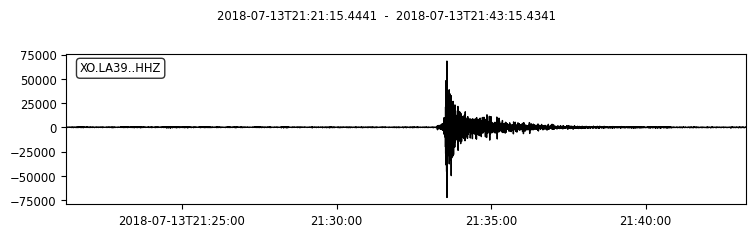

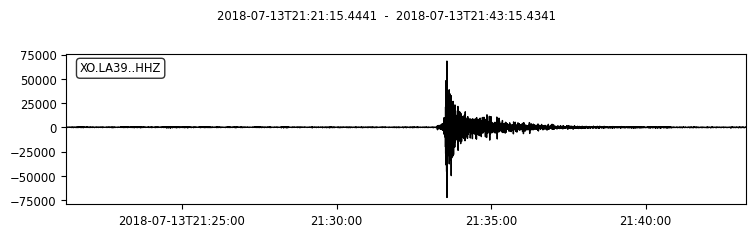

In [227]:
rotation,auto,cross=get_spectra(st[0],st[3],st[1],st[2])
correctlist = {'ZP':True, 'Z1': False, 'Z2-1': False, 'ZP-21': False, 'ZH': False, 'ZP-H': False}
transferfunc = gettransferfunc(rotation,auto,cross,correctlist)
correct = docorrection(st[0],st[3],st[1],st[2],transferfunc,correctlist)
print(correct['ZP'])
%matplotlib inline
fig = plt.figure()
st[3].plot()


In [ ]:
import obspy
import matplotlib.pyplot as plt
import numpy as np
import glob
import pandas as pd
import time; import datetime
from obspy.core.utcdatetime import UTCDateTime
from obspy.clients.fdsn.client import Client
import pyasdf
import obsmaster as obs
from seisgo.downloaders import download,get_sta_list

starttime=UTCDateTime('2018-07-13T21:21:15.442200Z')
endtime=UTCDateTime('2018-07-13T21:43:15.434200Z')
samp_freq=100

# Get traces from IRIS
net="XO"
sta="LA39"
chan=["HH1","HH2","HHZ","HDH"]
pchan=['HDH']
fmin=0.001
fmax=20
stalist=get_sta_list(net,sta,chan,starttime,endtime,pressure_chan=pchan)
print(stalist)

trall,stinvall=download(starttime, endtime, stationinfo=stalist,
                source='IRIS',rawdatadir=None,sacheader=True, getstainv=True,
                savetofile=False,pressure_chan=pchan,samp_freq=samp_freq,freqmin=fmin,freqmax=fmax,
                rmresp=True, rmresp_out='DISP',qc=True,verbose=True)
print(trall)
tr1,tr2,trZ,trP=trall
%matplotlib inline
fig = plt.figure()
trall.plot(fig = fig) 
plt.show()

# Ensure no NaNs in data
if np.sum(np.isnan(trZ.data)) > 0 or np.sum(np.isnan(trP.data)) >0 or \
        np.sum(np.isnan(tr1.data)) >0 or np.sum(np.isnan(tr2.data)) >0:
        print('Found NaN in data. Skip!')


# Correct for tilt and compliance
# your data is 22 minutes or 1320 seconds, window=1000 gives errors when computing the spectra (too small). 
# This is a bug we can address.  I can add you as a contributor. Feel free to suggest changes/fixes.
correct=obs.TCremoval_wrapper(
        tr1,tr2,trZ,trP,window=600,overlap=0.2,merge_taper=0.08,
        qc_freq=[0.004, 0.2],qc_spectra=False,fig_spectra=False,
        save_spectrafig=False,fig_transfunc=False)[2]
print(correct)


In [ ]:
obs.plotcorrection(trZ,correct)
correct_stats = trZ.stats
correct_trace = obspy.core.trace.Trace(data=correct['ZP'],header=correct_stats)
correct_trace.stats.channel='HHZ_TC1'
trall.append(correct_trace)
%matplotlib inline
fig1 = plt.figure()
trall[2].plot(fig = fig1) 
plt.show()
fig = plt.figure()
correct_trace.plot(fig = fig) 
plt.show()



In [ ]:
ds = pyasdf.ASDFDataSet('templates_0928.h5')

window=1000
overlap=0.1
taper=0.08

for station in ds.waveforms:
    tags=station.get_waveform_tags()
    for tag in tags:
        st=eval('station.'+tag)
        if len(st)<4:
            continue
        ev_id=tag[14:]
        stacode=st[0].stats.station
        for meta in ds.auxiliary_data['Metadata']:
            if (meta.path=='XO_'+stacode+'_'+str(ev_id)):
                mag = meta.parameters['magnitude']
                elev = meta.parameters['station_elev']
                break

        # Get traces from IRIS

        fmin=0.001
        fmax=20
        starttime=st[0].stats.starttime
        endtime = st[0].stats.endtime
        samp_freq=100
        print(st)
        channel = [st[1].stats.channel,st[2].stats.channel,st[3].stats.channel,st[0].stats.channel]
        print(channel)
        stalist = get_sta_list('XO',stacode,channel,starttime,endtime,pressure_chan=st[0].stats.channel)

        print(stalist)

        trall,stinvall=download(starttime, endtime, stationinfo=stalist,
                        source='IRIS',rawdatadir=None,sacheader=True, getstainv=True,
                        savetofile=False,pressure_chan=pchan,samp_freq=samp_freq,freqmin=fmin,freqmax=fmax,
                        rmresp=True, rmresp_out='DISP',qc=True,verbose=True)
        tr1,tr2,trZ,trP=trall
        
        # Ensure no NaNs in data
        if np.sum(np.isnan(trZ.data)) > 0 or np.sum(np.isnan(trP.data)) >0 or \
            np.sum(np.isnan(tr1.data)) >0 or np.sum(np.isnan(tr2.data)) >0:
            print('Found NaN in data. Skip!')
        correct=obs.TCremoval_wrapper(
            tr1,tr2,trZ,trP,window=600,overlap=0.2,merge_taper=0.08,
            qc_freq=[0.004, 0.2],qc_spectra=False,fig_spectra=False,
            save_spectrafig=False,fig_transfunc=False)[2]
        
        try:
            obs.plotcorrection(trZ,correct)
        except:
            print('oh well')

In [6]:
ds = pyasdf.ASDFDataSet('templates_shallow.h5')

for station in ds.waveforms:
    tags=station.get_waveform_tags()
    for tag in tags:
        st=eval('station.'+tag)
        print(st)
        for meta in ds.auxiliary_data['Metadata']:
            if (meta.path=='XO_'+stacode+'_'+str(ev_id)):
                mag = meta.parameters['magnitude']
                elev = meta.parameters['station_elev']
                break
                
            
        # Resample the pressure channel to 100 Hz:
        st.resample(100)
        
        # Make sure all traces are the same length:
        for trace in st:
            if trace.stats.npts != 132000:
                trace.trim(starttime = trace.stats.starttime,endtime = trace.stats.endtime-(.01*(trace.stats.npts-132000)))

        n2 = st[3].stats.npts
        f = np.fft.rfftfreq(n2,1/st[3].stats.sampling_rate)
        ftZ = np.fft.fft(st[3].data,n=n2)
        ftP = np.fft.fft(st[0].data,n=n2)
        cZZ = np.abs(ftZ*np.conj(ftZ))
        cPP = np.abs(ftP * np.conj(ftP))
        cPZ = np.abs(np.conj(ftP)*ftZ)
        transPZ = cPZ / cPP
        zcorr_spec = ftZ - (ftP * transPZ)
        zcorr = np.fft.ifft(zcorr_spec)

        %matplotlib inline
        fig = plt.figure(clear=True)
        plt.plot(np.linspace(0,st[0].stats.npts,num=st[0].stats.npts),np.real(zcorr),figure=fig)
        plt.plot(np.linspace(0,st[0].stats.npts,num=st[0].stats.npts),st[3].data,figure=fig)
        plt.title('Magnitude = '+str(mag)+', depth = '+str(elev))
        plt.show(fig)
        fig2 = plt.figure(clear=True)
        spec1 = plt.specgram(st[3].data,Fs=100,figure=fig2,vmin=1,vmax=100)
        plt.show(fig2)
        fig3 = plt.figure(clear=True)
        spec2 = plt.specgram(np.real(zcorr),Fs=100,figure=fig3,vmin=1,vmax=100)
        plt.show(fig3)

BlockingIOError: [Errno 35] Unable to open file (unable to lock file, errno = 35, error message = 'Resource temporarily unavailable')

In [11]:
import akcatalog_utils as akcat

month = '2018_08'#,'2018_08','2018_09']#,'2018_10','2018_11','2018_12','2019_01','2019_02']


# Load catalog info for one month
(assoc,arrivals,origin) = akcat.read_files(month)

11
29
10
68
262
LT07


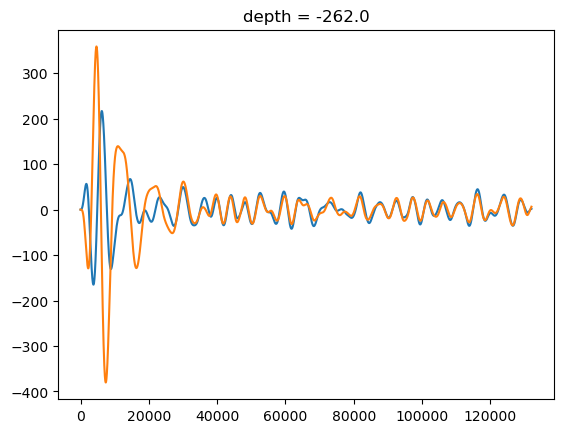

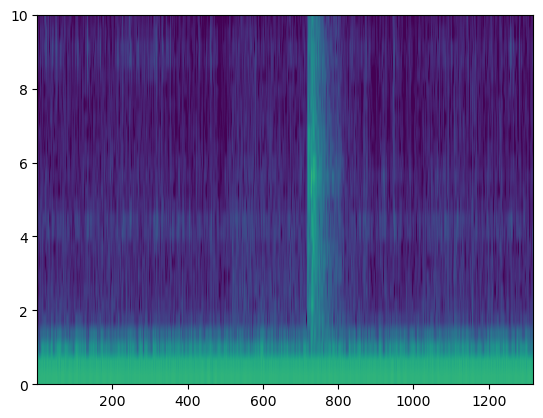

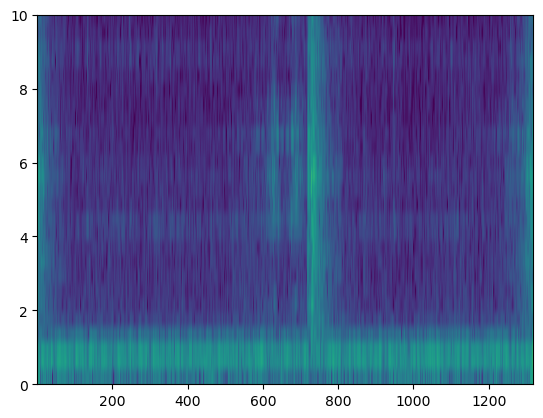

140
270
208
224
243
222
115
461
124
338
427
223
504
241
341
445
430
334
LT13


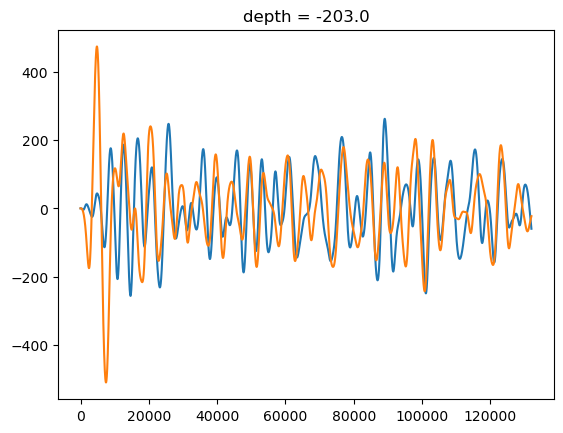

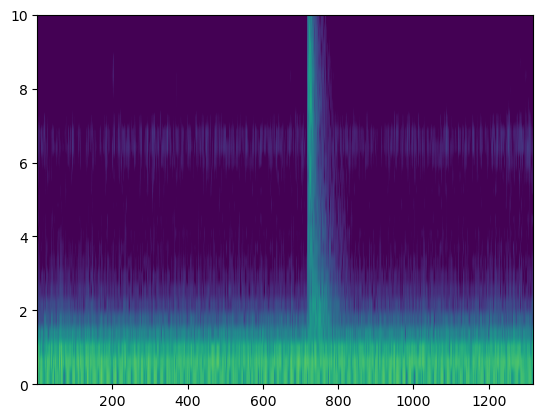

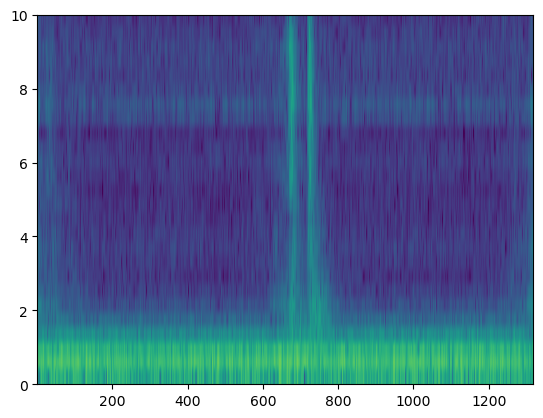

LT15


IndexError: list index out of range

In [30]:
import akcatalog_utils as akcat
from obspy.signal.filter import bandpass

# Sort events by magnitude, descending
origin = origin.sort_values(by=['magnitude'],ascending=False,ignore_index=True)
origin_ids = origin['originid']


ev_count = -1
client = Client('Iris')
# Loop through events
for id in origin_ids:
    # Get magnitude for this earthquake
    ev_count += 1
    mag = origin.iloc[ev_count]['magnitude']
    # ml_id = origin.iloc[ev_count]['quakeml_id']


    # Make sure event is not within 20 minutes of any other in the catalog
    diff = origin['epochtime']-(origin.iloc[ev_count]['epochtime'])
    if len((np.where(abs(diff)<(20*60)))[0])>1:
        continue

    # Get list of stations that have both P and S pick
    arrival_subset,repeat_subset = akcat.get_stationlist(arrivals,assoc,origin,index=int(id))

    # Loop over stations
    for i in range(0,len(repeat_subset)):
        pick = repeat_subset.iloc[i]
        station = pick['stationcode']

        try:
            station_mda = client.get_stations(network="XO", station=station)
        except:
            continue
        elev = station_mda[0][0].elevation
        if elev > -10:
            break
        if elev < -1000:
            break

        print(station)      
        p_pick = arrival_subset.loc[(arrival_subset['stationcode']==station)&(arrival_subset['phase']=='P')]
        s_pick = arrival_subset.loc[(arrival_subset['stationcode']==station)&(arrival_subset['phase']=='S')]
        p_time = datetime.datetime.utcfromtimestamp(p_pick.iloc[0]['epochtime'])
        s_time = datetime.datetime.utcfromtimestamp(s_pick.iloc[0]['epochtime'])
        sptime = float(str((s_time-p_time).seconds)+'.'+str((s_time-p_time).microseconds)) # S - P time in seconds

        # We want the streams for 12 minutes before and 10 min after the P:
        t1 = UTCDateTime(p_time)-datetime.timedelta(minutes = 12)
        t2 = UTCDateTime(p_time)+datetime.timedelta(minutes = 10)
        channel_base = p_pick.iloc[0]['channel'][0:2]
        channels = [channel_base+'Z',channel_base+'E,'+channel_base+'1',channel_base+'N,'+channel_base+'2']
        
        try:
            st = client.get_waveforms("XO",station, "--",channels[0]+','+channels[1]+','+channels[2]+',HDH', t1, t2,attach_response=True)
        except:
            continue
        
        #st.remove_response(output='DISP')
        zcorr = akcat.remove_compliance(st)
        

        fig = plt.figure(clear=True)
        # plt.plot(np.linspace(0,st[0].stats.npts,num=st[0].stats.npts),np.real(zcorr),figure=fig)
        # plt.plot(np.linspace(0,st[0].stats.npts,num=st[0].stats.npts),st[3].data,figure=fig)
        plt.plot(np.linspace(0,st[0].stats.npts,num=st[0].stats.npts),bandpass(np.real(zcorr),0.01,0.025,100),figure=fig)
        plt.plot(np.linspace(0,st[0].stats.npts,num=st[0].stats.npts),bandpass(st[3].data,0.01,0.025,100),figure=fig)
        plt.title('depth = '+str(elev))
        plt.show(fig)
        fig2 = plt.figure(clear=True)
        spec1 = plt.specgram(st[3].data,Fs=100,figure=fig2,vmin=0,vmax=100)
        plt.ylim(0,10)
        plt.show(fig2)
        fig3 = plt.figure(clear=True)
        spec2 = plt.specgram(np.real(zcorr),Fs=100,figure=fig3,vmin=0,vmax=100)
        plt.ylim(0,10)
        plt.show(fig3)
